# Downloads


In [1]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 12 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (476 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 144786 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 12 not upgraded.
Need to get 783 kB of 

In [2]:
!pip install gym # need Python 3.5+

In [3]:
pip install --ignore-installed pip 

     |████████████████████████████████| 1.5MB 4.5MB/s 


In [4]:
pip install gym[all]

     |████████████████████████████████| 120 kB 5.7 MB/s 
     |████████████████████████████████| 448 kB 18.4 MB/s 
     |████████████████████████████████| 203 kB 30.1 MB/s 
  ERROR: Failed building wheel for mujoco-py
  Running setup.py clean for mujoco-py
Failed to build mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-v0c_4i8t/mujoco-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-v0c_4i8t/mujoco-py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-_2b6gc7s/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.6/mujoco-py Check the logs for full command output.


In [5]:
!pip3 install box2d-py

  Using cached box2d_py-2.3.8-cp36-cp36m-manylinux1_x86_64.whl (448 kB)


In [6]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [7]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [8]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [9]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [10]:
pip install gym[classic_control]

In [11]:
pip install pyglet

Discrete(2)
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


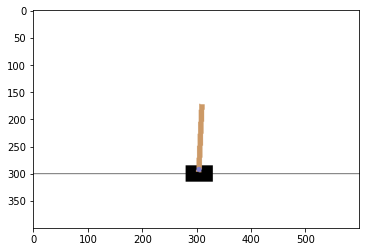

In [12]:
import gym
import pyglet
env = gym.make('CartPole-v1') #The system is controlled by applying a force of +1 or -1 to the cart, and the goal is to prevent the pole from falling over.
env.reset()
plt.imshow(env.render('rgb_array'))
print(env.action_space)
print(env.observation_space)

# Dueling DQN

In [13]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
class DuelDeepQNetwork(nn.Module):
  def __init__(self,lr,input_dims,fc1_dims,fc2_dims,n_actions):
    super(DuelDeepQNetwork, self).__init__()
    self.fc1_dims = fc1_dims
    self.fc2_dims = fc2_dims
    self.n_actions = n_actions
    self.fc1 = nn.Linear(*input_dims,self.fc1_dims)
    self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

    self.V = nn.Linear(self.fc2_dims, 1)
    self.A = nn.Linear(self.fc2_dims, self.n_actions)

    self.optimizer = optim.Adam(self.parameters(),lr=lr)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
      layer1 = F.relu(self.fc1(state.float()))
      layer2 = F.relu(self.fc2(layer1))

      V = self.V(layer2)
      A = self.A(layer2)

      return V,A

In [14]:
import collections
class QlearningAgent:
    # def __init__(self, env,epsilon=1.0,lr=0.6,gamma=0.9):
    def __init__(self, env,input_dims,n_actions,epsilon=1.0,lr=0.6,gamma=0.9,
                 batch_size=300,max_mem_size=1000,C=10,fc_d1=8,fc_d2=16):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        # q_table_dim = env.table_dim

        # self.q_table = np.zeros((q_table_dim,q_table_dim,env.action_space.n))
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma

        self.batch_size = batch_size
        self.max_mem_size=max_mem_size
        self.tracker = 0

        self.Q_eval = DuelDeepQNetwork(lr=self.lr,input_dims=input_dims,n_actions=self.action_space.n,fc1_dims=fc_d1,fc2_dims=fc_d2) #change
        self.Q_eval_hat = DuelDeepQNetwork(lr=self.lr,input_dims=input_dims,n_actions=self.action_space.n,fc1_dims=fc_d1,fc2_dims=fc_d2) #change
        self.Q_eval_hat.load_state_dict(self.Q_eval.state_dict())
        self.cnt=0

        self.state_memory = np.zeros((self.max_mem_size,*input_dims),dtype=np.float)
        self.new_state_memory = np.zeros((self.max_mem_size,*input_dims),dtype=np.float)

        self.action_memory = np.zeros(self.max_mem_size, dtype=np.float)
        self.reward_memory = np.zeros(self.max_mem_size, dtype=np.float)
        self.terminal_memory = np.zeros(self.max_mem_size, dtype=np.bool)

        self.C = C

    def step(self,observation):

      if random.uniform(0,1)<self.epsilon:
        action = np.random.choice(self.action_space.n)
        return action
      else:
      #  Ask Neural Network
        state = T.tensor([observation]).to(self.Q_eval.device)
        v,x = self.Q_eval.forward(state)
        # return np.argmax(self.q_table[int(observation[0]),int(observation[1])])
        return int(T.argmax(x))
    
    def store(self,state,action,reward,next_state,done):
     # Storing Code starts
      index = self.cnt%self.max_mem_size
      self.state_memory[index] = state
      self.new_state_memory[index] = next_state
      self.action_memory[index] = action
      self.reward_memory[index] = reward
      self.terminal_memory[index] = done
      # Storing Code Ends
    def setEpsilon(self,epsilon):
      self.epsilon = epsilon

    def learn(self):
          #New Code Starts

          self.cnt+=1
          if self.cnt<self.batch_size:
            return
          mem = min(self.cnt,self.max_mem_size)
          batch = np.random.choice(mem,self.batch_size,replace=False)
          

          for index in batch:
            self.Q_eval.optimizer.zero_grad()
            # q_update = self.reward_memory[index]
            q_update = T.tensor(float(self.reward_memory[index])).to(self.Q_eval.device)

            if not self.terminal_memory[index]:
              next_state_batch=T.tensor(self.new_state_memory[index]).to(self.Q_eval.device)     
              q_state_hat, q_next_actions_hat = self.Q_eval_hat.forward(next_state_batch)

              q_target = T.add(q_state_hat,q_next_actions_hat-T.mean(q_next_actions_hat))
              q_update = self.reward_memory[index] + self.gamma*T.max(q_target)

            state_batch=T.tensor(self.state_memory[index]).to(self.Q_eval.device)
            q_state, q_next_actions = self.Q_eval.forward(state_batch)

            q_val = T.add(q_state,q_next_actions-T.mean(q_next_actions))
            q_update.detach()
            loss = self.Q_eval.loss(q_val,q_update)
            loss.backward()
            self.Q_eval.optimizer.step()
          
          if self.cnt%self.C==0:
            self.Q_eval_hat.load_state_dict(self.Q_eval.state_dict())


In [15]:
# setting up environment and agent
import gym
env = gym.make('CartPole-v1') 
env.reset()

# agent = QlearningAgent(env=env,input_dims=[4],n_actions=2,epsilon=1.0,lr=0.003,gamma=0.9,batch_size=64,max_mem_size=1000)
agent = QlearningAgent(env=env,input_dims=[4],n_actions=2,epsilon=1.0,lr=0.001
                       ,gamma=0.95,batch_size=64,max_mem_size=10000,C=10000,fc_d1=8,fc_d2=16)

episodes = 500
min_epsilon = 0.1

q_d_epsilons = []

q_d_rewards = []

for episode in range(episodes):
  print(episode)
  obs = env.reset()
  done = False
  q_d_epsilons.append(agent.epsilon)

  curr_reward = 0

  while not done:
    action = agent.step(obs)
    state = np.copy(obs)
    obs, reward, done, info = env.step(action)
    curr_reward+=reward
    next_state = np.copy(obs)
    agent.store(state,action,reward,next_state,done)
    agent.learn()
  q_d_rewards.append(curr_reward)
  epsilon = max(min_epsilon,agent.epsilon*0.995)
  agent.setEpsilon(epsilon)
  # if not episode%100:
  #        env.render()
  #        plt.show()
  #        print('Episode {}'.format(episode))
  #        print('Epsilon {}'.format(q_d_epsilons[-1]))
         
  #        print('***************************************************')

0
1
2


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278


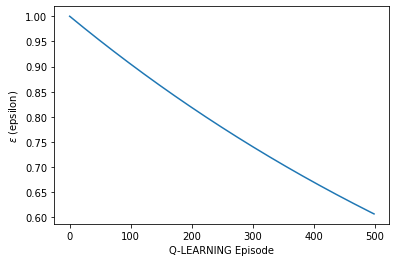

In [16]:
plt.xlabel('Cartpole Dueling DQN Episode')
plt.ylabel('$\epsilon$ (epsilon)')
plt.plot(q_d_epsilons)

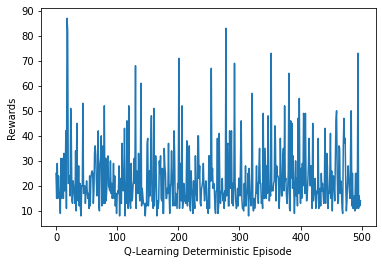

In [18]:
window = 1
plt.xlabel('Cartpole Dueling DQN Deterministic Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(q_d_rewards[tr:tr+window]) for tr in range(window, len(q_d_rewards))])